In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the dataset
data = pd.read_csv('homework_3.1.csv')
print("Dataset Information:")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"Time range: {data['time'].min()} to {data['time'].max()}")
print("\nFirst few rows:")
print(data.head())
print("\nDataset statistics:")
print(data.describe())

Dataset Information:
Shape: (100, 5)
Columns: ['Unnamed: 0', 'time', 'value1', 'value2', 'value3']
Time range: 0 to 99

First few rows:
   Unnamed: 0  time    value1    value2    value3
0           0     0  1.764052  1.883151 -0.369182
1           1     1  0.420157 -1.327759 -0.219379
2           2     2  1.018738 -1.230485  1.139660
3           3     3  2.300893  1.029397  0.715264
4           4     4  1.947558 -1.093123  0.720132

Dataset statistics:
       Unnamed: 0        time      value1      value2      value3
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean    49.500000   49.500000    2.152308    1.807013    2.155768
std     29.011492   29.011492    2.052524    1.557664    2.126580
min      0.000000    0.000000   -2.152990   -1.327759   -1.516956
25%     24.750000   24.750000    0.543743    0.963499    0.340994
50%     49.500000   49.500000    1.948924    1.723450    1.816849
75%     74.250000   74.250000    3.433771    2.796829    3.912036
max     99.0000

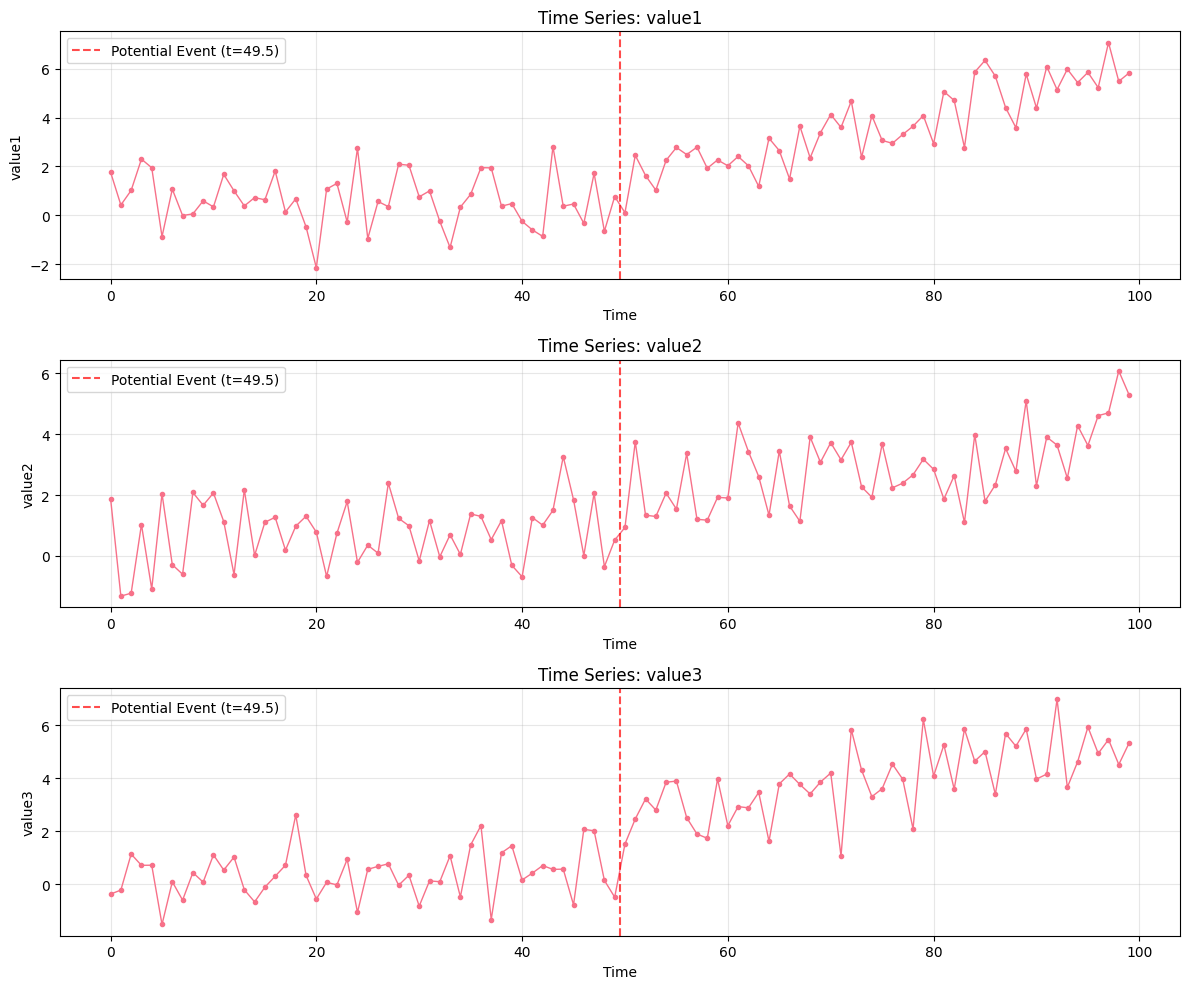

Potential event time (median): 49.5
Data points before event: 50
Data points after event: 50


In [3]:
# Visualize the time series data to identify potential event points
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot each value column
for i, col in enumerate(['value1', 'value2', 'value3']):
    axes[i].plot(data['time'], data[col], 'o-', linewidth=1, markersize=3)
    axes[i].set_title(f'Time Series: {col}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    
    # Add vertical line at potential event points (middle of time series)
    event_time = data['time'].median()
    axes[i].axvline(x=event_time, color='red', linestyle='--', alpha=0.7, label=f'Potential Event (t={event_time})')
    axes[i].legend()

plt.tight_layout()
plt.show()

print(f"Potential event time (median): {event_time}")
print(f"Data points before event: {len(data[data['time'] < event_time])}")
print(f"Data points after event: {len(data[data['time'] >= event_time])}")

In [5]:
def test_discontinuity_value_only(time, values, event_time):
    """
    Test for discontinuity in value only (not slope) using linear regression.
    This model allows for a jump in the intercept at the event time but maintains the same slope.
    
    Model: y = β0 + β1*t + β2*D + ε
    where D is a dummy variable that equals 1 after the event time, 0 before
    """
    
    # Create dummy variable for post-event period
    dummy_post_event = (time >= event_time).astype(int)
    
    # Prepare features matrix
    X = np.column_stack([
        np.ones(len(time)),  # intercept
        time,                # time trend
        dummy_post_event     # discontinuity dummy
    ])
    
    # Fit the model using statsmodels for better statistical output
    model = sm.OLS(values, X).fit()
    
    # Extract coefficients
    beta0, beta1, beta2 = model.params
    
    # Statistical test for discontinuity (H0: β2 = 0)
    discontinuity_pvalue = model.pvalues[2]
    discontinuity_tstat = model.tvalues[2]
    
    # Confidence interval for the discontinuity
    discontinuity_ci = model.conf_int().iloc[2]
    
    results = {
        'model': model,
        'beta0_intercept': beta0,
        'beta1_slope': beta1,
        'beta2_discontinuity': beta2,
        'discontinuity_pvalue': discontinuity_pvalue,
        'discontinuity_tstat': discontinuity_tstat,
        'discontinuity_ci': discontinuity_ci,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'aic': model.aic,
        'bic': model.bic,
        'predictions': model.fittedvalues
    }
    
    return results

# Test function with value1 as an example
event_time = data['time'].median()
results_value1 = test_discontinuity_value_only(data['time'], data['value1'], event_time)

print("=== TEST 1: DISCONTINUITY IN VALUE ONLY (value1) ===")
print(f"Event time: {event_time}")
print(f"Intercept (β0): {results_value1['beta0_intercept']:.4f}")
print(f"Slope (β1): {results_value1['beta1_slope']:.4f}")
print(f"Discontinuity (β2): {results_value1['beta2_discontinuity']:.4f}")
print(f"Discontinuity p-value: {results_value1['discontinuity_pvalue']:.6f}")
print(f"Discontinuity t-statistic: {results_value1['discontinuity_tstat']:.4f}")
print(f"95% CI for discontinuity: [{results_value1['discontinuity_ci'].iloc[0]:.4f}, {results_value1['discontinuity_ci'].iloc[1]:.4f}]")
print(f"R-squared: {results_value1['r_squared']:.4f}")
print(f"Adjusted R-squared: {results_value1['adj_r_squared']:.4f}")

# Interpretation
alpha = 0.05
if results_value1['discontinuity_pvalue'] < alpha:
    print(f"\n** CONCLUSION: There IS a statistically significant discontinuity in value at t={event_time} (p < {alpha})")
else:
    print(f"\n** CONCLUSION: There is NO statistically significant discontinuity in value at t={event_time} (p >= {alpha})")

print(f"\nThe estimated jump in value at the event is: {results_value1['beta2_discontinuity']:.4f}")

=== TEST 1: DISCONTINUITY IN VALUE ONLY (value1) ===
Event time: 49.5
Intercept (β0): -0.4439
Slope (β1): 0.0439
Discontinuity (β2): 0.8508
Discontinuity p-value: 0.085607
Discontinuity t-statistic: 1.7367
95% CI for discontinuity: [-0.1215, 1.8231]
R-squared: 0.6513
Adjusted R-squared: 0.6441

** CONCLUSION: There is NO statistically significant discontinuity in value at t=49.5 (p >= 0.05)

The estimated jump in value at the event is: 0.8508


In [7]:
def test_discontinuity_slope_and_value(time, values, event_time):
    """
    Test for discontinuity in both value and slope using linear regression.
    This model allows for different intercepts and slopes before and after the event.
    
    Model: y = β0 + β1*t + β2*D + β3*(D*t) + ε
    where:
    - D is a dummy variable (1 after event, 0 before)
    - D*t is the interaction term allowing slope change
    """
    
    # Create dummy variable and interaction term
    dummy_post_event = (time >= event_time).astype(int)
    interaction_term = dummy_post_event * time
    
    # Prepare features matrix
    X = np.column_stack([
        np.ones(len(time)),  # intercept
        time,                # time trend
        dummy_post_event,    # discontinuity in value
        interaction_term     # discontinuity in slope
    ])
    
    # Fit the model
    model = sm.OLS(values, X).fit()
    
    # Extract coefficients
    beta0, beta1, beta2, beta3 = model.params
    
    # Statistical tests
    value_discontinuity_pvalue = model.pvalues[2]  # Test for β2 = 0
    slope_discontinuity_pvalue = model.pvalues[3]  # Test for β3 = 0
    
    # Joint test for both discontinuities (F-test)
    # H0: β2 = β3 = 0 (no discontinuity in either value or slope)
    restriction_matrix = np.array([[0, 0, 1, 0], [0, 0, 0, 1]])  # Test β2=0 and β3=0
    joint_test = model.f_test(restriction_matrix)
    
    results = {
        'model': model,
        'beta0_intercept': beta0,
        'beta1_pre_slope': beta1,
        'beta2_value_discontinuity': beta2,
        'beta3_slope_discontinuity': beta3,
        'post_event_slope': beta1 + beta3,  # Slope after event
        'value_discontinuity_pvalue': value_discontinuity_pvalue,
        'slope_discontinuity_pvalue': slope_discontinuity_pvalue,
        'joint_test_pvalue': joint_test.pvalue,
        'joint_test_fstat': joint_test.fvalue,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'aic': model.aic,
        'bic': model.bic,
        'predictions': model.fittedvalues
    }
    
    return results

# Test function with value1
results_slope_value1 = test_discontinuity_slope_and_value(data['time'], data['value1'], event_time)

print("=== TEST 2: DISCONTINUITY IN BOTH VALUE AND SLOPE (value1) ===")
print(f"Event time: {event_time}")
print(f"Pre-event intercept (β0): {results_slope_value1['beta0_intercept']:.4f}")
print(f"Pre-event slope (β1): {results_slope_value1['beta1_pre_slope']:.4f}")
print(f"Value discontinuity (β2): {results_slope_value1['beta2_value_discontinuity']:.4f}")
print(f"Slope discontinuity (β3): {results_slope_value1['beta3_slope_discontinuity']:.4f}")
print(f"Post-event slope (β1 + β3): {results_slope_value1['post_event_slope']:.4f}")

print(f"\nIndividual Tests:")
print(f"Value discontinuity p-value: {results_slope_value1['value_discontinuity_pvalue']:.6f}")
print(f"Slope discontinuity p-value: {results_slope_value1['slope_discontinuity_pvalue']:.6f}")

print(f"\nJoint Test (both discontinuities):")
print(f"F-statistic: {results_slope_value1['joint_test_fstat']:.4f}")
print(f"Joint test p-value: {results_slope_value1['joint_test_pvalue']:.6f}")

print(f"\nModel fit:")
print(f"R-squared: {results_slope_value1['r_squared']:.4f}")
print(f"Adjusted R-squared: {results_slope_value1['adj_r_squared']:.4f}")

# Interpretations
alpha = 0.05
print(f"\n=== INTERPRETATIONS (α = {alpha}) ===")

if results_slope_value1['value_discontinuity_pvalue'] < alpha:
    print(f"✓ Significant VALUE discontinuity detected (p = {results_slope_value1['value_discontinuity_pvalue']:.6f})")
else:
    print(f"✗ No significant VALUE discontinuity (p = {results_slope_value1['value_discontinuity_pvalue']:.6f})")

if results_slope_value1['slope_discontinuity_pvalue'] < alpha:
    print(f"✓ Significant SLOPE discontinuity detected (p = {results_slope_value1['slope_discontinuity_pvalue']:.6f})")
else:
    print(f"✗ No significant SLOPE discontinuity (p = {results_slope_value1['slope_discontinuity_pvalue']:.6f})")

if results_slope_value1['joint_test_pvalue'] < alpha:
    print(f"✓ Joint test: Significant discontinuity overall (p = {results_slope_value1['joint_test_pvalue']:.6f})")
else:
    print(f"✗ Joint test: No significant discontinuity overall (p = {results_slope_value1['joint_test_pvalue']:.6f})")

=== TEST 2: DISCONTINUITY IN BOTH VALUE AND SLOPE (value1) ===
Event time: 49.5
Pre-event intercept (β0): 0.8464
Pre-event slope (β1): -0.0088
Value discontinuity (β2): -4.3628
Slope discontinuity (β3): 0.1053
Post-event slope (β1 + β3): 0.0965

Individual Tests:
Value discontinuity p-value: 0.000000
Slope discontinuity p-value: 0.000000

Joint Test (both discontinuities):
F-statistic: 34.0868
Joint test p-value: 0.000000

Model fit:
R-squared: 0.7897
Adjusted R-squared: 0.7832

=== INTERPRETATIONS (α = 0.05) ===
✓ Significant VALUE discontinuity detected (p = 0.000000)
✓ Significant SLOPE discontinuity detected (p = 0.000000)
✓ Joint test: Significant discontinuity overall (p = 0.000000)


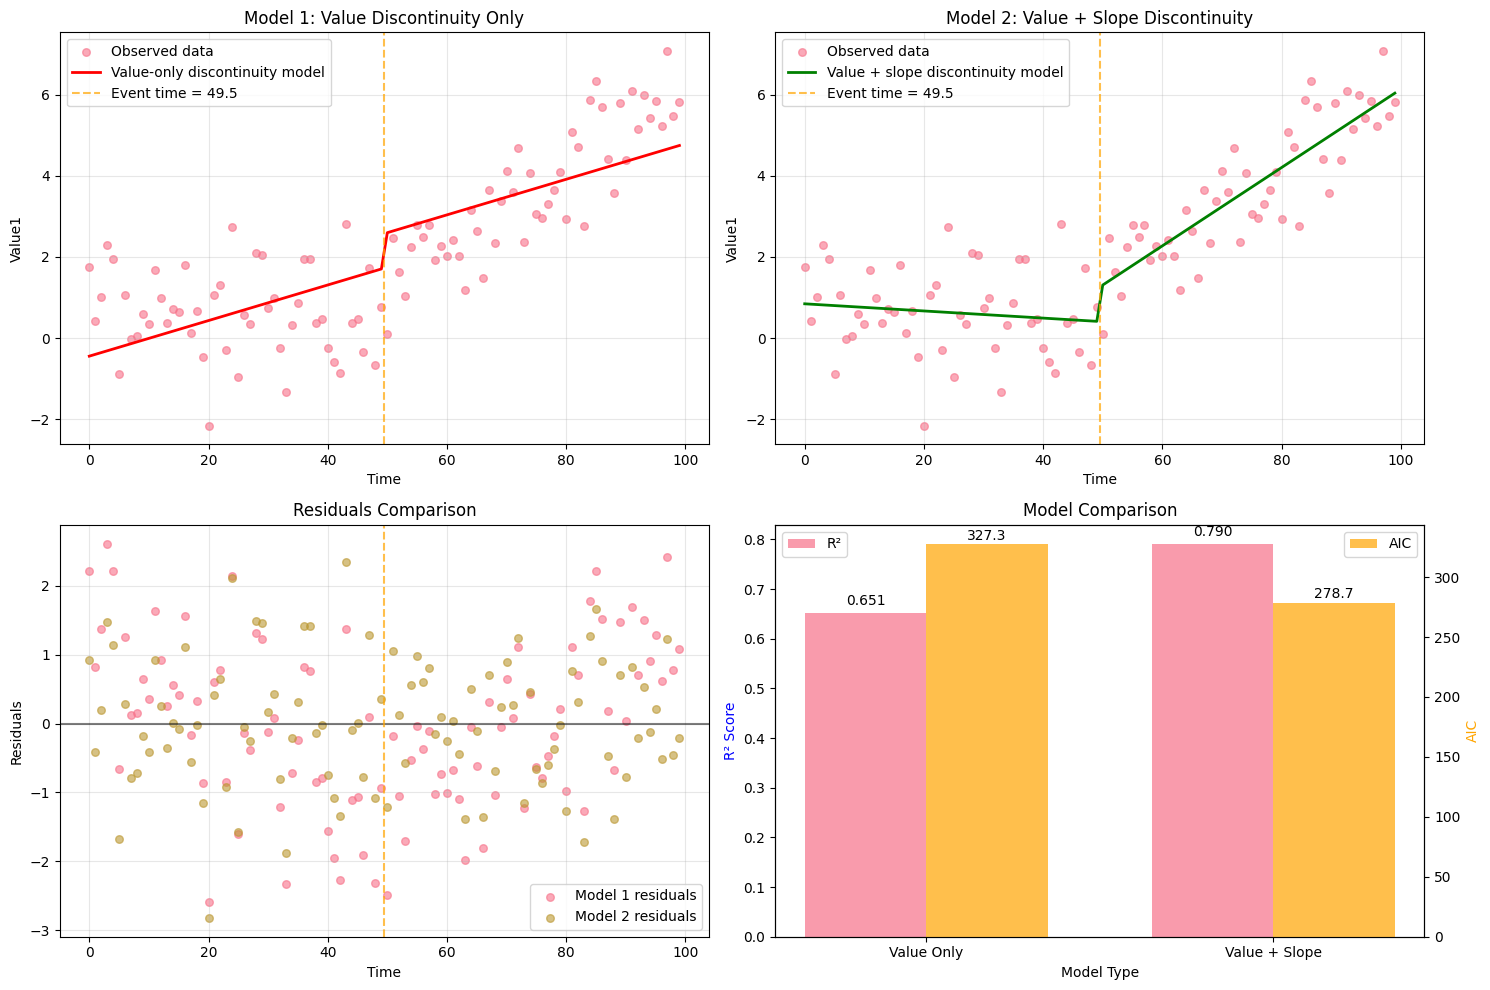

=== MODEL COMPARISON SUMMARY (value1) ===
Model 1 (Value discontinuity only):
  - R²: 0.6513
  - AIC: 327.25
  - Discontinuity p-value: 0.085607

Model 2 (Value + slope discontinuity):
  - R²: 0.7897
  - AIC: 278.66
  - Joint test p-value: 0.000000

** BEST MODEL: Value + slope discontinuity (lower AIC: 278.66)
AIC difference: 48.60
This represents a meaningful difference between models.


In [8]:
# Visualize the regression results for value1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original data with value-only discontinuity model
ax1 = axes[0, 0]
ax1.scatter(data['time'], data['value1'], alpha=0.6, s=30, label='Observed data')
ax1.plot(data['time'], results_value1['predictions'], 'r-', linewidth=2, label='Value-only discontinuity model')
ax1.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7, label=f'Event time = {event_time}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value1')
ax1.set_title('Model 1: Value Discontinuity Only')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Original data with slope+value discontinuity model
ax2 = axes[0, 1]
ax2.scatter(data['time'], data['value1'], alpha=0.6, s=30, label='Observed data')
ax2.plot(data['time'], results_slope_value1['predictions'], 'g-', linewidth=2, label='Value + slope discontinuity model')
ax2.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7, label=f'Event time = {event_time}')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value1')
ax2.set_title('Model 2: Value + Slope Discontinuity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals comparison
ax3 = axes[1, 0]
residuals1 = data['value1'] - results_value1['predictions']
residuals2 = data['value1'] - results_slope_value1['predictions']
ax3.scatter(data['time'], residuals1, alpha=0.6, label='Model 1 residuals', s=30)
ax3.scatter(data['time'], residuals2, alpha=0.6, label='Model 2 residuals', s=30)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7)
ax3.set_xlabel('Time')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Model comparison metrics
ax4 = axes[1, 1]
models = ['Value Only', 'Value + Slope']
r_squared = [results_value1['r_squared'], results_slope_value1['r_squared']]
aic_values = [results_value1['aic'], results_slope_value1['aic']]

x = np.arange(len(models))
width = 0.35

ax4_twin = ax4.twinx()
bars1 = ax4.bar(x - width/2, r_squared, width, label='R²', alpha=0.7)
bars2 = ax4_twin.bar(x + width/2, aic_values, width, label='AIC', alpha=0.7, color='orange')

ax4.set_xlabel('Model Type')
ax4.set_ylabel('R² Score', color='blue')
ax4_twin.set_ylabel('AIC', color='orange')
ax4.set_title('Model Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(models)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    ax4.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.01,
             f'{r_squared[i]:.3f}', ha='center', va='bottom')
    ax4_twin.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 1,
                  f'{aic_values[i]:.1f}', ha='center', va='bottom')

ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Model comparison summary
print("=== MODEL COMPARISON SUMMARY (value1) ===")
print(f"Model 1 (Value discontinuity only):")
print(f"  - R²: {results_value1['r_squared']:.4f}")
print(f"  - AIC: {results_value1['aic']:.2f}")
print(f"  - Discontinuity p-value: {results_value1['discontinuity_pvalue']:.6f}")

print(f"\nModel 2 (Value + slope discontinuity):")
print(f"  - R²: {results_slope_value1['r_squared']:.4f}")
print(f"  - AIC: {results_slope_value1['aic']:.2f}")
print(f"  - Joint test p-value: {results_slope_value1['joint_test_pvalue']:.6f}")

# Determine better model (lower AIC is better)
if results_value1['aic'] < results_slope_value1['aic']:
    print(f"\n** BEST MODEL: Value discontinuity only (lower AIC: {results_value1['aic']:.2f})")
else:
    print(f"\n** BEST MODEL: Value + slope discontinuity (lower AIC: {results_slope_value1['aic']:.2f})")

aic_diff = abs(results_value1['aic'] - results_slope_value1['aic'])
print(f"AIC difference: {aic_diff:.2f}")
if aic_diff > 2:
    print("This represents a meaningful difference between models.")
else:
    print("This represents a small difference between models.")

In [9]:
# Analyze all three value columns
print("=== COMPREHENSIVE ANALYSIS FOR ALL VALUE COLUMNS ===\n")

results_summary = {}

for col in ['value1', 'value2', 'value3']:
    print(f"--- Analysis for {col} ---")
    
    # Test both models
    results_val_only = test_discontinuity_value_only(data['time'], data[col], event_time)
    results_val_slope = test_discontinuity_slope_and_value(data['time'], data[col], event_time)
    
    results_summary[col] = {
        'value_only': results_val_only,
        'value_slope': results_val_slope
    }
    
    # Print key results
    print(f"Value-only model:")
    print(f"  Discontinuity: {results_val_only['beta2_discontinuity']:.4f} (p = {results_val_only['discontinuity_pvalue']:.6f})")
    print(f"  R²: {results_val_only['r_squared']:.4f}, AIC: {results_val_only['aic']:.2f}")
    
    print(f"Value+slope model:")
    print(f"  Value discontinuity: {results_val_slope['beta2_value_discontinuity']:.4f} (p = {results_val_slope['value_discontinuity_pvalue']:.6f})")
    print(f"  Slope discontinuity: {results_val_slope['beta3_slope_discontinuity']:.4f} (p = {results_val_slope['slope_discontinuity_pvalue']:.6f})")
    print(f"  Joint test p-value: {results_val_slope['joint_test_pvalue']:.6f}")
    print(f"  R²: {results_val_slope['r_squared']:.4f}, AIC: {results_val_slope['aic']:.2f}")
    
    # Significance test
    alpha = 0.05
    has_value_disc = results_val_only['discontinuity_pvalue'] < alpha
    has_slope_disc = results_val_slope['slope_discontinuity_pvalue'] < alpha
    has_any_disc = results_val_slope['joint_test_pvalue'] < alpha
    
    print(f"  Significant discontinuities: ", end="")
    if has_value_disc and has_slope_disc:
        print("Both value and slope")
    elif has_value_disc:
        print("Value only")
    elif has_slope_disc:
        print("Slope only")
    elif has_any_disc:
        print("Some discontinuity (joint test)")
    else:
        print("None detected")
    
    print()

=== COMPREHENSIVE ANALYSIS FOR ALL VALUE COLUMNS ===

--- Analysis for value1 ---
Value-only model:
  Discontinuity: 0.8508 (p = 0.085607)
  R²: 0.6513, AIC: 327.25
Value+slope model:
  Value discontinuity: -4.3628 (p = 0.000000)
  Slope discontinuity: 0.1053 (p = 0.000000)
  Joint test p-value: 0.000000
  R²: 0.7897, AIC: 278.66
  Significant discontinuities: Slope only

--- Analysis for value2 ---
Value-only model:
  Discontinuity: 0.6827 (p = 0.113103)
  R²: 0.5399, AIC: 299.78
Value+slope model:
  Value discontinuity: -1.1449 (p = 0.168061)
  Slope discontinuity: 0.0369 (p = 0.011811)
  Joint test p-value: 0.011860
  R²: 0.5695, AIC: 295.15
  Significant discontinuities: Slope only

--- Analysis for value3 ---
Value-only model:
  Discontinuity: 1.7673 (p = 0.000033)
  R²: 0.7773, AIC: 289.50
Value+slope model:
  Value discontinuity: -0.7422 (p = 0.326893)
  Slope discontinuity: 0.0507 (p = 0.000208)
  Joint test p-value: 0.000000
  R²: 0.8072, AIC: 277.10
  Significant discontinuit

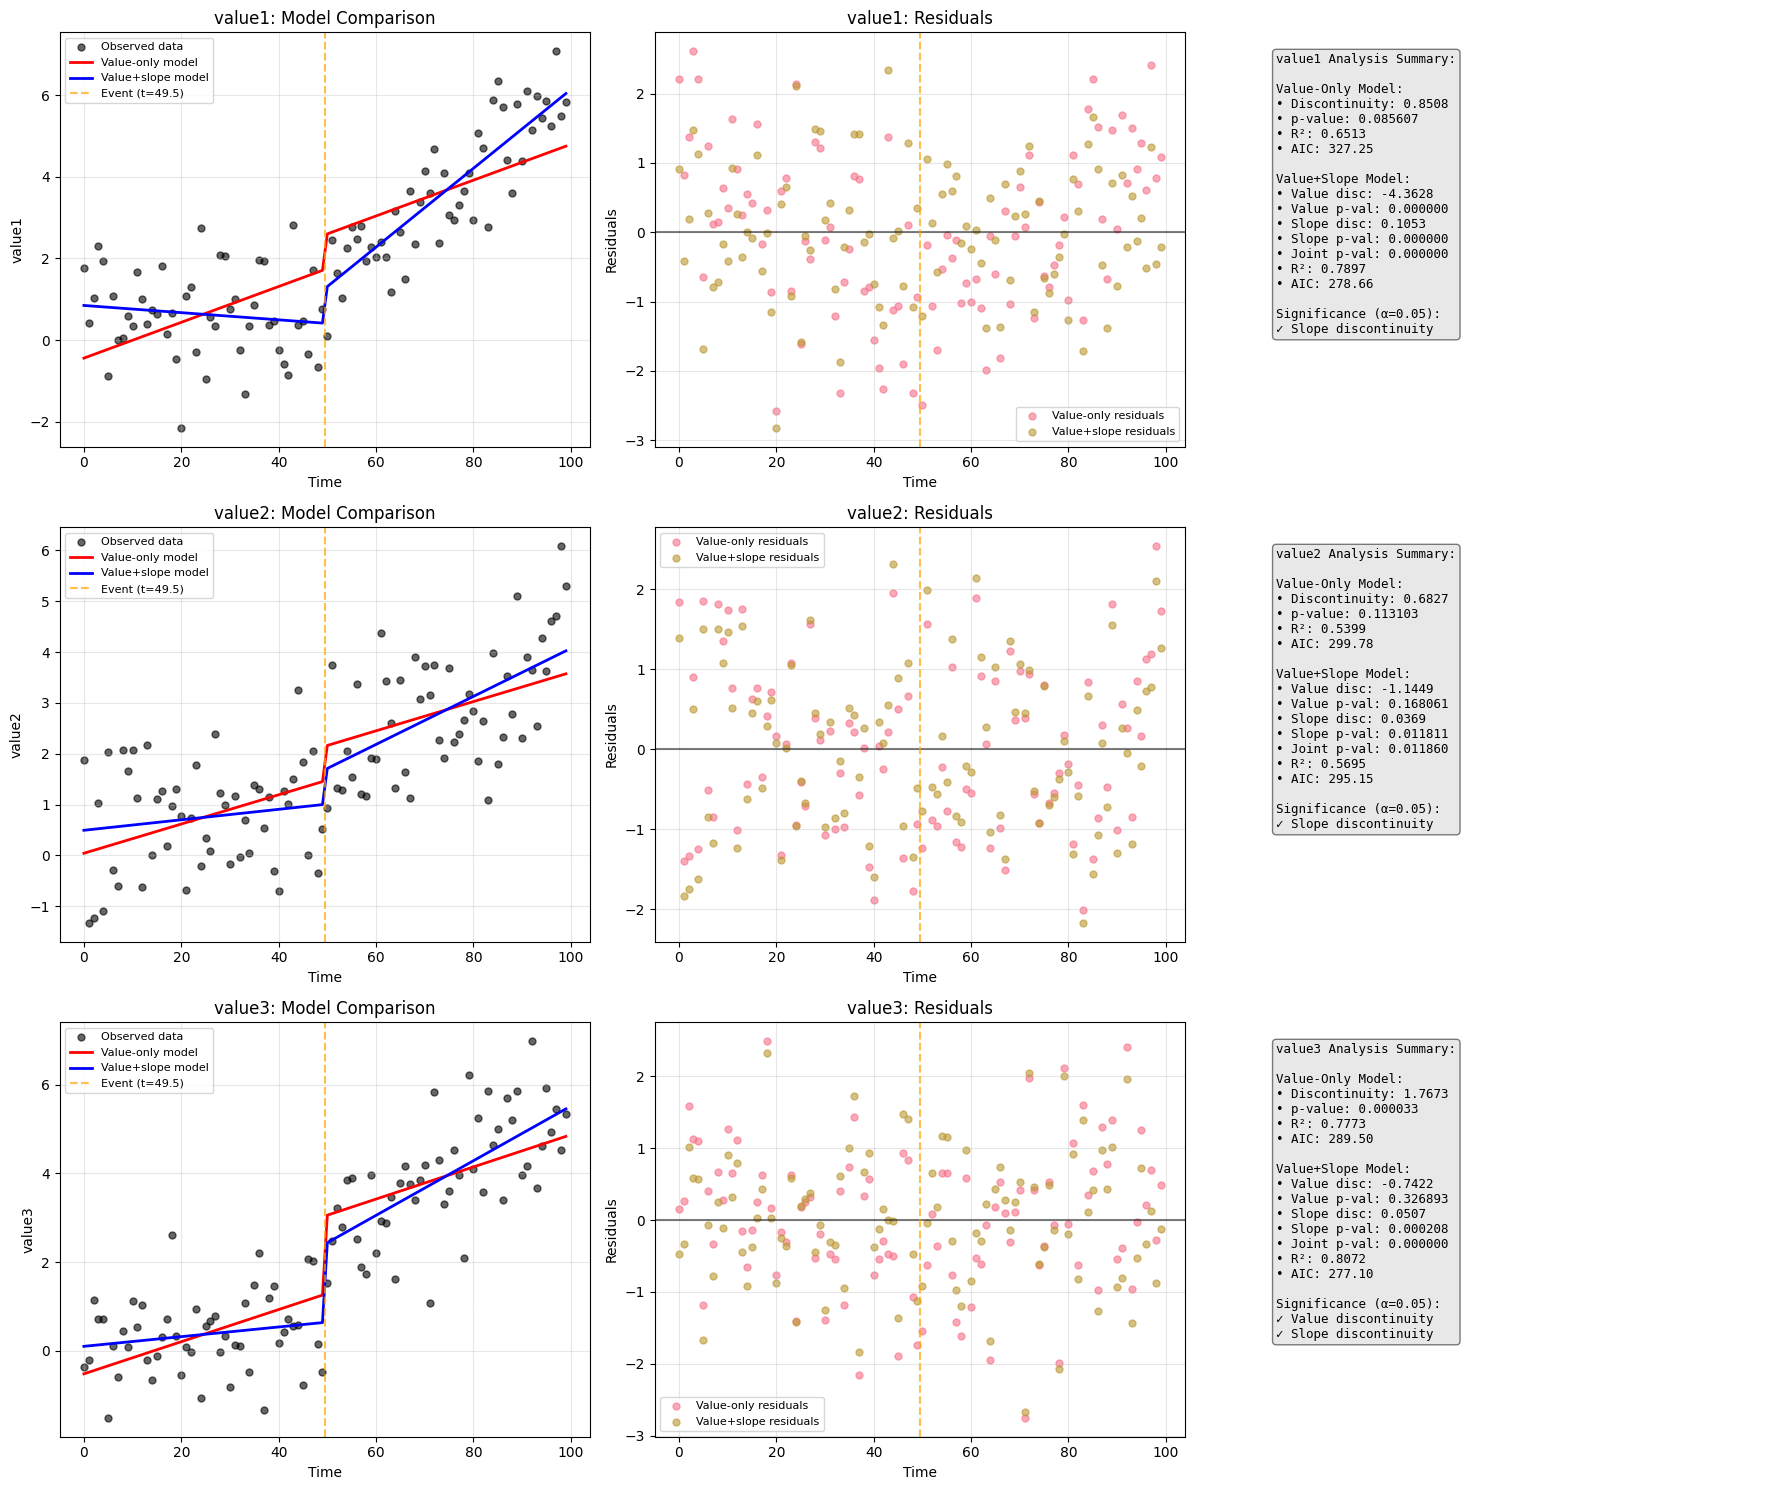

In [10]:
# Create comprehensive visualization for all columns
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for i, col in enumerate(['value1', 'value2', 'value3']):
    results_val_only = results_summary[col]['value_only']
    results_val_slope = results_summary[col]['value_slope']
    
    # Plot 1: Data with both models
    ax1 = axes[i, 0]
    ax1.scatter(data['time'], data[col], alpha=0.6, s=25, label='Observed data', color='black')
    ax1.plot(data['time'], results_val_only['predictions'], 'r-', linewidth=2, label='Value-only model')
    ax1.plot(data['time'], results_val_slope['predictions'], 'b-', linewidth=2, label='Value+slope model')
    ax1.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7, label=f'Event (t={event_time})')
    ax1.set_title(f'{col}: Model Comparison')
    ax1.set_xlabel('Time')
    ax1.set_ylabel(col)
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    ax2 = axes[i, 1]
    residuals_val = data[col] - results_val_only['predictions']
    residuals_slope = data[col] - results_val_slope['predictions']
    ax2.scatter(data['time'], residuals_val, alpha=0.6, s=25, label='Value-only residuals')
    ax2.scatter(data['time'], residuals_slope, alpha=0.6, s=25, label='Value+slope residuals')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axvline(x=event_time, color='orange', linestyle='--', alpha=0.7)
    ax2.set_title(f'{col}: Residuals')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Residuals')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Statistical summary
    ax3 = axes[i, 2]
    ax3.axis('off')
    
    # Create text summary
    summary_text = f"""{col} Analysis Summary:

Value-Only Model:
• Discontinuity: {results_val_only['beta2_discontinuity']:.4f}
• p-value: {results_val_only['discontinuity_pvalue']:.6f}
• R²: {results_val_only['r_squared']:.4f}
• AIC: {results_val_only['aic']:.2f}

Value+Slope Model:
• Value disc: {results_val_slope['beta2_value_discontinuity']:.4f}
• Value p-val: {results_val_slope['value_discontinuity_pvalue']:.6f}
• Slope disc: {results_val_slope['beta3_slope_discontinuity']:.4f}
• Slope p-val: {results_val_slope['slope_discontinuity_pvalue']:.6f}
• Joint p-val: {results_val_slope['joint_test_pvalue']:.6f}
• R²: {results_val_slope['r_squared']:.4f}
• AIC: {results_val_slope['aic']:.2f}

Significance (α=0.05):"""
    
    # Add significance indicators
    alpha = 0.05
    if results_val_only['discontinuity_pvalue'] < alpha:
        summary_text += f"\n✓ Value discontinuity"
    if results_val_slope['slope_discontinuity_pvalue'] < alpha:
        summary_text += f"\n✓ Slope discontinuity"
    if results_val_slope['joint_test_pvalue'] < alpha and \
       (results_val_only['discontinuity_pvalue'] >= alpha and results_val_slope['slope_discontinuity_pvalue'] >= alpha):
        summary_text += f"\n✓ Some discontinuity (joint)"
    if (results_val_only['discontinuity_pvalue'] >= alpha and 
        results_val_slope['slope_discontinuity_pvalue'] >= alpha and 
        results_val_slope['joint_test_pvalue'] >= alpha):
        summary_text += f"\n✗ No significant discontinuity"
    
    ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes, fontsize=9,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.show()

In [11]:
# Final summary table
print("=== FINAL SUMMARY TABLE ===")
print("="*80)

summary_df = pd.DataFrame({
    'Variable': ['value1', 'value2', 'value3'],
    'Value_Discontinuity': [results_summary[col]['value_only']['beta2_discontinuity'] for col in ['value1', 'value2', 'value3']],
    'Value_pvalue': [results_summary[col]['value_only']['discontinuity_pvalue'] for col in ['value1', 'value2', 'value3']],
    'Slope_Discontinuity': [results_summary[col]['value_slope']['beta3_slope_discontinuity'] for col in ['value1', 'value2', 'value3']],
    'Slope_pvalue': [results_summary[col]['value_slope']['slope_discontinuity_pvalue'] for col in ['value1', 'value2', 'value3']],
    'Joint_pvalue': [results_summary[col]['value_slope']['joint_test_pvalue'] for col in ['value1', 'value2', 'value3']],
    'Best_Model_AIC': [min(results_summary[col]['value_only']['aic'], results_summary[col]['value_slope']['aic']) for col in ['value1', 'value2', 'value3']]
})

# Add significance indicators
alpha = 0.05
summary_df['Value_Significant'] = (summary_df['Value_pvalue'] < alpha).map({True: '✓', False: '✗'})
summary_df['Slope_Significant'] = (summary_df['Slope_pvalue'] < alpha).map({True: '✓', False: '✗'})
summary_df['Joint_Significant'] = (summary_df['Joint_pvalue'] < alpha).map({True: '✓', False: '✗'})

# Determine best model for each variable
summary_df['Preferred_Model'] = [
    'Value+Slope' if results_summary[col]['value_slope']['aic'] < results_summary[col]['value_only']['aic'] 
    else 'Value-Only' for col in ['value1', 'value2', 'value3']
]

print(summary_df.round(4))

print(f"\n=== KEY FINDINGS ===")
print(f"Event time analyzed: {event_time}")
print(f"Significance level: α = {alpha}")
print()

for col in ['value1', 'value2', 'value3']:
    val_sig = results_summary[col]['value_only']['discontinuity_pvalue'] < alpha
    slope_sig = results_summary[col]['value_slope']['slope_discontinuity_pvalue'] < alpha
    joint_sig = results_summary[col]['value_slope']['joint_test_pvalue'] < alpha
    
    print(f"{col}:")
    if val_sig and slope_sig:
        print(f"  → Both value and slope discontinuities detected")
    elif val_sig:
        print(f"  → Value discontinuity only")
    elif slope_sig:
        print(f"  → Slope discontinuity only")
    elif joint_sig:
        print(f"  → Some form of discontinuity (joint test significant)")
    else:
        print(f"  → No significant discontinuity detected")
        
    print(f"  → Estimated value jump: {summary_df[summary_df['Variable']==col]['Value_Discontinuity'].values[0]:.4f}")
    if slope_sig:
        print(f"  → Estimated slope change: {summary_df[summary_df['Variable']==col]['Slope_Discontinuity'].values[0]:.4f}")

print(f"\n=== METHODOLOGICAL NOTES ===")
print(f"• Value-only model: y = β₀ + β₁t + β₂D + ε")
print(f"  where D=1 after event, 0 before")
print(f"• Value+slope model: y = β₀ + β₁t + β₂D + β₃(D×t) + ε")
print(f"  where D×t allows slope change after event")
print(f"• Joint test examines H₀: β₂ = β₃ = 0")
print(f"• Lower AIC indicates better model fit")

=== FINAL SUMMARY TABLE ===
  Variable  Value_Discontinuity  Value_pvalue  Slope_Discontinuity  \
0   value1               0.8508        0.0856               0.1053   
1   value2               0.6827        0.1131               0.0369   
2   value3               1.7673        0.0000               0.0507   

   Slope_pvalue  Joint_pvalue  Best_Model_AIC Value_Significant  \
0        0.0000        0.0000        278.6594                 ✗   
1        0.0118        0.0119        295.1474                 ✗   
2        0.0002        0.0000        277.0969                 ✓   

  Slope_Significant Joint_Significant Preferred_Model  
0                 ✓                 ✓     Value+Slope  
1                 ✓                 ✓     Value+Slope  
2                 ✓                 ✓     Value+Slope  

=== KEY FINDINGS ===
Event time analyzed: 49.5
Significance level: α = 0.05

value1:
  → Slope discontinuity only
  → Estimated value jump: 0.8508
  → Estimated slope change: 0.1053
value2:
  → Slo

# Differences-in-Differences (DiD) Analysis

Now we'll implement a differences-in-differences regression analysis using the treatment/control datasets. DiD is a quasi-experimental technique that compares the changes in outcomes over time between treatment and control groups to estimate causal effects.

In [12]:
# Load the DiD datasets
data_a = pd.read_csv('homework_3.2.a.csv')
data_b = pd.read_csv('homework_3.2.b.csv')

print("=== DATASET EXPLORATION ===")
print(f"Dataset A shape: {data_a.shape}")
print(f"Dataset B shape: {data_b.shape}")

print(f"\nDataset A - Group distribution:")
print(data_a['group1'].value_counts().sort_index())
print(f"Dataset A - Time distribution:")
print(data_a['time1'].value_counts().sort_index())

print(f"\nDataset B - Group distribution:")
print(data_b['group2'].value_counts().sort_index())
print(f"Dataset B - Time distribution:")
print(data_b['time2'].value_counts().sort_index())

print("\nDataset A sample:")
print(data_a.head())
print("\nDataset B sample:")
print(data_b.head())

=== DATASET EXPLORATION ===
Dataset A shape: (1000, 4)
Dataset B shape: (1000, 4)

Dataset A - Group distribution:
group1
0    501
1    499
Name: count, dtype: int64
Dataset A - Time distribution:
time1
0    500
1    500
Name: count, dtype: int64

Dataset B - Group distribution:
group2
0    501
1    499
Name: count, dtype: int64
Dataset B - Time distribution:
time2
0    500
1    500
Name: count, dtype: int64

Dataset A sample:
   Unnamed: 0  group1  time1  outcome1
0           0       0      0  0.882026
1           1       0      1  1.600079
2           2       0      0  0.489369
3           3       0      1  2.520447
4           4       0      0  0.933779

Dataset B sample:
   Unnamed: 0  group2  time2  outcome2
0           0       0      0  0.667155
1           1       0      1  2.470969
2           2       0      0 -0.506778
3           3       0      1  1.525657
4           4       0      0  0.273664


In [13]:
def perform_did_analysis(data, group_col, time_col, outcome_col, dataset_name):
    """
    Perform differences-in-differences analysis on a single dataset.
    
    DiD Model: Y = β0 + β1*Treatment + β2*Post + β3*(Treatment*Post) + ε
    
    Where:
    - β0: baseline outcome for control group before treatment
    - β1: difference between treatment and control groups before intervention
    - β2: change in control group from before to after
    - β3: DiD estimator (treatment effect)
    """
    
    # Create the regression variables
    treatment = data[group_col]  # 1 if treatment group, 0 if control
    post = data[time_col]        # 1 if after period, 0 if before
    treatment_post = treatment * post  # Interaction term (DiD estimator)
    outcome = data[outcome_col]
    
    # Prepare design matrix
    X = np.column_stack([
        np.ones(len(data)),  # intercept
        treatment,           # treatment dummy
        post,               # post-period dummy  
        treatment_post      # interaction (DiD estimator)
    ])
    
    # Fit the model
    model = sm.OLS(outcome, X).fit()
    
    # Extract coefficients
    beta0, beta1, beta2, beta3 = model.params
    
    # Calculate group means for interpretation
    control_before = outcome[(treatment == 0) & (post == 0)].mean()
    control_after = outcome[(treatment == 0) & (post == 1)].mean()
    treatment_before = outcome[(treatment == 1) & (post == 0)].mean()
    treatment_after = outcome[(treatment == 1) & (post == 1)].mean()
    
    # Calculate differences
    control_change = control_after - control_before
    treatment_change = treatment_after - treatment_before
    did_estimate = treatment_change - control_change
    
    results = {
        'model': model,
        'beta0_intercept': beta0,
        'beta1_treatment_effect_pre': beta1,
        'beta2_time_effect': beta2,
        'beta3_did_estimator': beta3,
        'control_before': control_before,
        'control_after': control_after,
        'treatment_before': treatment_before,
        'treatment_after': treatment_after,
        'control_change': control_change,
        'treatment_change': treatment_change,
        'did_estimate_manual': did_estimate,
        'did_pvalue': model.pvalues[3],
        'did_tstat': model.tvalues[3],
        'did_ci': model.conf_int().iloc[3],
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'dataset_name': dataset_name
    }
    
    return results

# Analyze Dataset A
print("=== DIFFERENCES-IN-DIFFERENCES ANALYSIS ===\n")

results_a = perform_did_analysis(data_a, 'group1', 'time1', 'outcome1', 'Dataset A')
print("--- DATASET A RESULTS ---")
print(f"Control group before: {results_a['control_before']:.4f}")
print(f"Control group after:  {results_a['control_after']:.4f}")
print(f"Treatment group before: {results_a['treatment_before']:.4f}")
print(f"Treatment group after:  {results_a['treatment_after']:.4f}")

print(f"\nChanges over time:")
print(f"Control group change:    {results_a['control_change']:.4f}")
print(f"Treatment group change:  {results_a['treatment_change']:.4f}")

print(f"\nDiD Estimator (Treatment Effect): {results_a['beta3_did_estimator']:.4f}")
print(f"DiD p-value: {results_a['did_pvalue']:.6f}")
print(f"DiD 95% CI: [{results_a['did_ci'].iloc[0]:.4f}, {results_a['did_ci'].iloc[1]:.4f}]")

print(f"\nModel coefficients:")
print(f"β₀ (baseline): {results_a['beta0_intercept']:.4f}")
print(f"β₁ (treatment pre-effect): {results_a['beta1_treatment_effect_pre']:.4f}")  
print(f"β₂ (time effect): {results_a['beta2_time_effect']:.4f}")
print(f"β₃ (DiD treatment effect): {results_a['beta3_did_estimator']:.4f}")

# Statistical significance
alpha = 0.05
if results_a['did_pvalue'] < alpha:
    print(f"\n** CONCLUSION A: Statistically significant treatment effect detected (p < {alpha})")
else:
    print(f"\n** CONCLUSION A: No statistically significant treatment effect (p >= {alpha})")

=== DIFFERENCES-IN-DIFFERENCES ANALYSIS ===

--- DATASET A RESULTS ---
Control group before: -0.0258
Control group after:  1.4014
Treatment group before: 1.9604
Treatment group after:  4.0735

Changes over time:
Control group change:    1.4272
Treatment group change:  2.1131

DiD Estimator (Treatment Effect): 0.6858
DiD p-value: 0.000000
DiD 95% CI: [0.5632, 0.8085]

Model coefficients:
β₀ (baseline): -0.0258
β₁ (treatment pre-effect): 1.9863
β₂ (time effect): 1.4272
β₃ (DiD treatment effect): 0.6858

** CONCLUSION A: Statistically significant treatment effect detected (p < 0.05)


In [14]:
# Analyze Dataset B
results_b = perform_did_analysis(data_b, 'group2', 'time2', 'outcome2', 'Dataset B')

print("\n--- DATASET B RESULTS ---")
print(f"Control group before: {results_b['control_before']:.4f}")
print(f"Control group after:  {results_b['control_after']:.4f}")
print(f"Treatment group before: {results_b['treatment_before']:.4f}")
print(f"Treatment group after:  {results_b['treatment_after']:.4f}")

print(f"\nChanges over time:")
print(f"Control group change:    {results_b['control_change']:.4f}")
print(f"Treatment group change:  {results_b['treatment_change']:.4f}")

print(f"\nDiD Estimator (Treatment Effect): {results_b['beta3_did_estimator']:.4f}")
print(f"DiD p-value: {results_b['did_pvalue']:.6f}")
print(f"DiD 95% CI: [{results_b['did_ci'].iloc[0]:.4f}, {results_b['did_ci'].iloc[1]:.4f}]")

print(f"\nModel coefficients:")
print(f"β₀ (baseline): {results_b['beta0_intercept']:.4f}")
print(f"β₁ (treatment pre-effect): {results_b['beta1_treatment_effect_pre']:.4f}")  
print(f"β₂ (time effect): {results_b['beta2_time_effect']:.4f}")
print(f"β₃ (DiD treatment effect): {results_b['beta3_did_estimator']:.4f}")

# Statistical significance
if results_b['did_pvalue'] < alpha:
    print(f"\n** CONCLUSION B: Statistically significant treatment effect detected (p < {alpha})")
else:
    print(f"\n** CONCLUSION B: No statistically significant treatment effect (p >= {alpha})")


--- DATASET B RESULTS ---
Control group before: 0.1021
Control group after:  1.3676
Treatment group before: 1.9498
Treatment group after:  4.5652

Changes over time:
Control group change:    1.2655
Treatment group change:  2.6154

DiD Estimator (Treatment Effect): 1.3499
DiD p-value: 0.000000
DiD 95% CI: [1.0613, 1.6384]

Model coefficients:
β₀ (baseline): 0.1021
β₁ (treatment pre-effect): 1.8477
β₂ (time effect): 1.2655
β₃ (DiD treatment effect): 1.3499

** CONCLUSION B: Statistically significant treatment effect detected (p < 0.05)


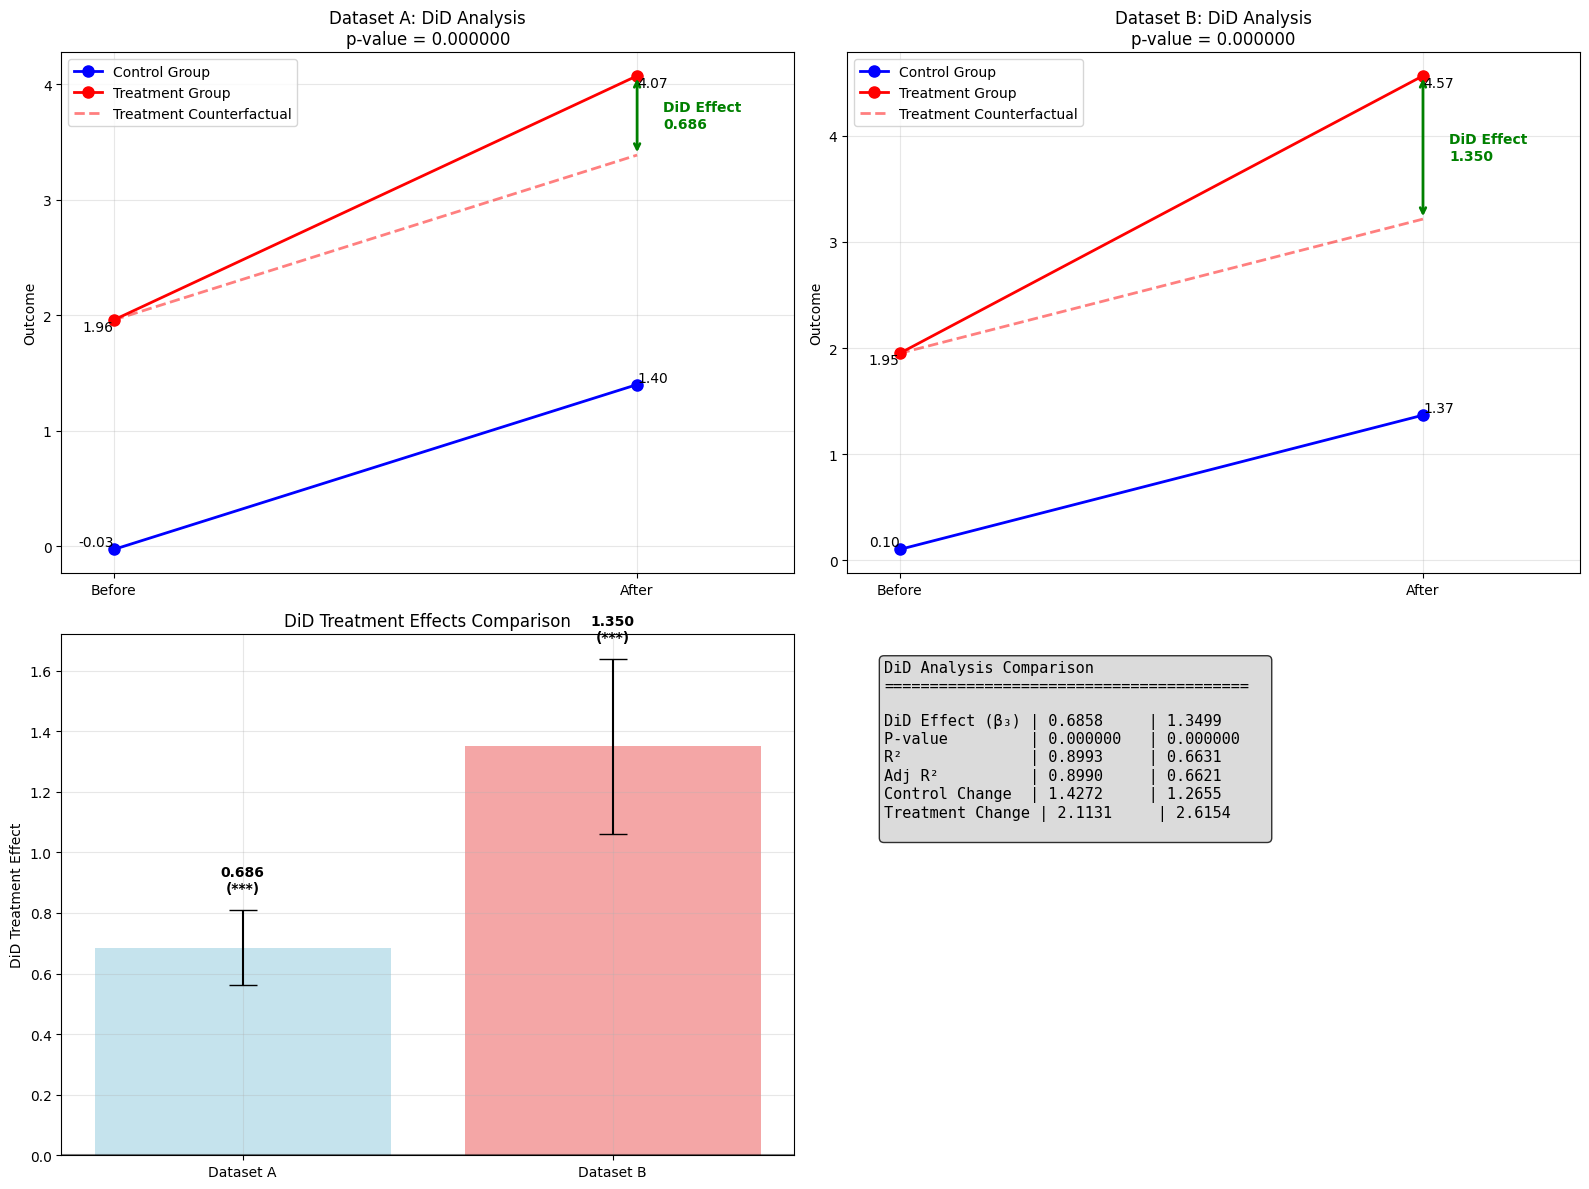

In [15]:
# Create comprehensive DiD visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

def create_did_plot(ax, results, title):
    """Create a DiD plot showing parallel trends and treatment effect"""
    
    # Data points
    groups = ['Control', 'Treatment']
    times = ['Before', 'After']
    
    # Control group trajectory
    control_before = results['control_before']
    control_after = results['control_after']
    
    # Treatment group trajectory  
    treatment_before = results['treatment_before']
    treatment_after = results['treatment_after']
    
    # Plot lines
    ax.plot([0, 1], [control_before, control_after], 'o-', 
            color='blue', linewidth=2, markersize=8, label='Control Group')
    ax.plot([0, 1], [treatment_before, treatment_after], 'o-', 
            color='red', linewidth=2, markersize=8, label='Treatment Group')
    
    # Add counterfactual line (what treatment group would have been without treatment)
    counterfactual_after = treatment_before + (control_after - control_before)
    ax.plot([0, 1], [treatment_before, counterfactual_after], '--', 
            color='red', alpha=0.5, linewidth=2, label='Treatment Counterfactual')
    
    # Highlight the DiD effect
    did_effect = results['beta3_did_estimator']
    ax.annotate('', xy=(1, treatment_after), xytext=(1, counterfactual_after),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
    ax.text(1.05, (treatment_after + counterfactual_after) / 2, 
            f'DiD Effect\n{did_effect:.3f}', 
            fontsize=10, ha='left', va='center', color='green', fontweight='bold')
    
    # Labels and formatting
    ax.set_xlim(-0.1, 1.3)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(times)
    ax.set_ylabel('Outcome')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add mean values as text
    ax.text(0, control_before, f'{control_before:.2f}', ha='right', va='bottom')
    ax.text(1, control_after, f'{control_after:.2f}', ha='left', va='bottom')
    ax.text(0, treatment_before, f'{treatment_before:.2f}', ha='right', va='top')
    ax.text(1, treatment_after, f'{treatment_after:.2f}', ha='left', va='top')

# Plot DiD for both datasets
create_did_plot(axes[0, 0], results_a, f'Dataset A: DiD Analysis\np-value = {results_a["did_pvalue"]:.6f}')
create_did_plot(axes[0, 1], results_b, f'Dataset B: DiD Analysis\np-value = {results_b["did_pvalue"]:.6f}')

# Create regression results comparison
ax3 = axes[1, 0]
datasets = ['Dataset A', 'Dataset B']
did_effects = [results_a['beta3_did_estimator'], results_b['beta3_did_estimator']]
did_errors = [
    (results_a['did_ci'].iloc[1] - results_a['did_ci'].iloc[0]) / 2,
    (results_b['did_ci'].iloc[1] - results_b['did_ci'].iloc[0]) / 2
]

bars = ax3.bar(datasets, did_effects, yerr=did_errors, capsize=10, alpha=0.7,
               color=['lightblue', 'lightcoral'])
ax3.set_ylabel('DiD Treatment Effect')
ax3.set_title('DiD Treatment Effects Comparison')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.grid(True, alpha=0.3)

# Add significance indicators
for i, (bar, result) in enumerate(zip(bars, [results_a, results_b])):
    height = bar.get_height()
    significance = '***' if result['did_pvalue'] < 0.001 else '**' if result['did_pvalue'] < 0.01 else '*' if result['did_pvalue'] < 0.05 else 'ns'
    ax3.text(bar.get_x() + bar.get_width()/2., height + did_errors[i] + 0.05,
             f'{height:.3f}\n({significance})', ha='center', va='bottom', fontweight='bold')

# Model statistics comparison table
ax4 = axes[1, 1]
ax4.axis('off')

stats_data = {
    'Statistic': ['DiD Effect (β₃)', 'P-value', 'R²', 'Adj R²', 'Control Change', 'Treatment Change'],
    'Dataset A': [
        f'{results_a["beta3_did_estimator"]:.4f}',
        f'{results_a["did_pvalue"]:.6f}',
        f'{results_a["r_squared"]:.4f}',
        f'{results_a["adj_r_squared"]:.4f}',
        f'{results_a["control_change"]:.4f}',
        f'{results_a["treatment_change"]:.4f}'
    ],
    'Dataset B': [
        f'{results_b["beta3_did_estimator"]:.4f}',
        f'{results_b["did_pvalue"]:.6f}',
        f'{results_b["r_squared"]:.4f}',
        f'{results_b["adj_r_squared"]:.4f}',
        f'{results_b["control_change"]:.4f}',
        f'{results_b["treatment_change"]:.4f}'
    ]
}

# Create table
table_text = "DiD Analysis Comparison\n" + "="*40 + "\n\n"
for i, stat in enumerate(stats_data['Statistic']):
    table_text += f"{stat:<15} | {stats_data['Dataset A'][i]:<10} | {stats_data['Dataset B'][i]:<10}\n"

ax4.text(0.05, 0.95, table_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

In [16]:
# Print detailed regression output for both datasets
print("=== DETAILED REGRESSION OUTPUT ===\n")

print("--- DATASET A REGRESSION SUMMARY ---")
print(results_a['model'].summary())

print("\n--- DATASET B REGRESSION SUMMARY ---")
print(results_b['model'].summary())

print("\n" + "="*80)
print("DiD INTERPRETATION GUIDE")
print("="*80)
print("""
The Differences-in-Differences model:
Y = β₀ + β₁*Treatment + β₂*Post + β₃*(Treatment*Post) + ε

Where:
• β₀: Baseline outcome for control group before intervention
• β₁: Pre-treatment difference between treatment and control groups  
• β₂: Change in control group from before to after (time trend)
• β₃: DiD estimator - the causal treatment effect

The DiD estimator (β₃) represents the treatment effect by comparing:
- How much the treatment group changed over time
- Minus how much the control group changed over time
- This difference-in-differences isolates the causal effect

Assumptions:
1. Parallel trends: Without treatment, both groups would follow similar trends
2. No spillover effects between groups
3. Treatment assignment is as-good-as-random conditional on group and time
""")

=== DETAILED REGRESSION OUTPUT ===

--- DATASET A REGRESSION SUMMARY ---
                            OLS Regression Results                            
Dep. Variable:               outcome1   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     2964.
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:36:23   Log-Likelihood:                -712.28
No. Observations:                1000   AIC:                             1433.
Df Residuals:                     996   BIC:                             1452.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------